In [ ]:
%run "./creds.ipynb"

In [ ]:
%run "./api_request.ipynb"

In [1]:
#import libraries
from netCDF4 import Dataset

import numpy as np
import xarray as xr
import pandas as pd


#establish API connection
#pull data

import cdsapi

api_key = get_api_key('copernicus')
url = 'https://ads.atmosphere.copernicus.eu/api/v2'

data_file = cdsapi.Client(url=url, key=api_key)

username, pw = get_username_pw()
start_dt = '2001-01-01'
end_dt = '2025-01-01'
minlong = -118
maxlong = -116
minlat = 33
maxlong = 35

aq_dataset = get_pm25_data(username, pw, start_date=start_dt, end_date=end_dt, minlong=minlong, maxlong=maxlong, minlat=minlat, maxlong=maxlong)

#2021-09-CAMS-Air-Quality-Data-Access

In [12]:
#temp data setup
from netCDF4 import Dataset

import numpy as np
import xarray as xr
import pandas as pd

sample_filename1 = "./MERRA2_400.tavgU_2d_aer_Nx.202411.nc4"
sample_filename2 = "./MERRA2_400.tavgU_2d_aer_Nx.202408.nc4"
sample_filename3 = "./MERRA2_400.tavgU_2d_aer_Nx.202409.nc4"
sample_filename4 = "./MERRA2_400.tavgU_2d_aer_Nx.202410.nc4"
aq_dataset = [sample_filename1, sample_filename2, sample_filename3, sample_filename4]
aq_data = xr.open_dataset(sample_filename)

In [15]:
def parse_long_lat(xarr_wide):
    weights = np.cos(np.deg2rad(xarr_wide.lat))
    xarr_weighted = xarr_wide.weighted(weights)
    xarr_flat = xarr_weighted.mean(dim=["lat", "lon"])
    return xarr_flat

aq_dfs = []
for file in aq_dataset:
    aq_xarr = parse_long_lat(xr.open_dataset(file))
    aq_dfs.append(aq_xarr)




In [17]:
def parse_long_lat(xarr_wide):
    weights = np.cos(np.deg2rad(xarr_wide.lat))
    xarr_weighted = xarr_wide.weighted(weights)
    xarr_flat = xarr_weighted.mean(dim=["lat", "lon"])
    return xarr_flat

aq_dfs = []
for file in aq_dataset:
    aq_xarr = parse_long_lat(xr.open_dataset(file))
    aq_dfs.append(aq_xarr)



aq_monthly_data = xr.concat(aq_dfs, dim="time")
aq_data_full = aq_monthly_data.assign(pm25=aq_data['DUSMASS25']+aq_data['SSSMASS25']+aq_data['BCSMASS']+aq_data['OCSMASS']+1.375*aq_data['SO4SMASS'])


In [28]:
aq_monthly_avg = aq_data_full.groupby('time.month').mean()

In [31]:
aq_monthly_avg.quantile(0.95, dim='month')

<xarray.Dataset>
Dimensions:    (lon: 576, lat: 361)
Coordinates:
  * lon        (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat        (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
    quantile   float64 0.95
Data variables: (12/51)
    BCANGSTR   float64 1.464
    BCCMASS    float64 1.083e-06
    BCEXTTAU   float64 0.01121
    BCFLUXU    float64 4.098e-06
    BCFLUXV    float64 -1.055e-07
    BCSCATAU   float64 0.002832
    ...         ...
    SUFLUXV    float64 -2.562e-07
    SUSCATAU   float64 0.03798
    TOTANGSTR  float64 0.9282
    TOTEXTTAU  float64 0.1702
    TOTSCATAU  float64 0.1598
    pm25       (lat, lon) float64 4.328e-10 4.328e-10 ... 1.787e-09 1.787e-09

In [30]:
aq_monthly_avg

<xarray.Dataset>
Dimensions:    (month: 4, lon: 576, lat: 361)
Coordinates:
  * lon        (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat        (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * month      (month) int64 8 9 10 11
Data variables: (12/51)
    BCANGSTR   (month) float64 1.462 1.463 1.463 1.464
    BCCMASS    (month) float64 9.747e-07 1.103e-06 7.902e-07 5.709e-07
    BCEXTTAU   (month) float64 0.01007 0.01141 0.008278 0.006029
    BCFLUXU    (month) float64 2.171e-06 4.101e-06 4.078e-06 2.482e-06
    BCFLUXV    (month) float64 -9.661e-08 -7.306e-07 -1.556e-07 -2.069e-07
    BCSCATAU   (month) float64 0.002527 0.002886 0.002137 0.001572
    ...         ...
    SUFLUXV    (month) float64 -2.597e-07 -2.952e-07 -2.555e-07 -1.047e-06
    SUSCATAU   (month) float64 0.03817 0.0369 0.03531 0.03683
    TOTANGSTR  (month) float64 0.8851 0.9341 0.8946 0.8126
    TOTEXTTAU  (month) float64 0.1706 0.1678 0.1397 0.1223
    TOTSCATAU  (month) float64 0.1603 0.1569 0.1317 0.1165
    pm25       (month, lat, lon) float32 nan nan nan ... 1.787e-09 1.787e-09

In [ ]:
#parse and clean data
def calculate_pm25(data_vals):
    
    pm25 = DUSMASS25 + SSSMASS25 + BCSMASS + OCSMASS + 1.375*SO4SMASS + 1.29*NISMASS25
    return pm25
    
#add in pm25 variable
aq_data_full = aq_data.assign(pm25=aq_data['DUSMASS25']+aq_data['SSSMASS25']+aq_data['BCSMASS']+aq_data['OCSMASS']+1.375*aq_data['SO4SMASS']*100000000)


#condense lat/lons so that date is the only axis
weights = np.cos(np.deg2rad(aq_data_full.latitude))
aq_df_weighted = aq_data_full.weighted(weights)
aq_data = ds_weighted.mean(dim=["latitude", "longitude"])
#time -- min -- max -- avg -- max(pm25 - other pm25) -> range
#dt -- min(min) -- max(max) -- avg(avg) --max(range)

#plot data pm25_over_time
    #basic map of region in question
    #air quality in chosen over time
    #max, min, average each month

aq_data = aq_data_full.groupBy('

In [ ]:
#region map
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


df = aq_data['PM25']
# create the figure panel and specify size
fig = plt.figure(figsize=(15, 10))

# create the map using the cartopy PlateCarree projection
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

# Add lat/lon grid
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Plot the data
im = plt.pcolormesh(df.lon, df.lat, df[0,:,:], cmap='YlOrRd', vmin=0, vmax=2) 

# Add coastlines
ax.coastlines(color='black') 

# Specify the colourbar, including fraction of original axes to use for colorbar, 
# and fraction of original axes between colorbar and new image axes
cbar = plt.colorbar(im, fraction=0.025, pad=0.05)

# Define the colourbar label
cbar.set_label('Average PM 2.5 Levels, Monthly') 

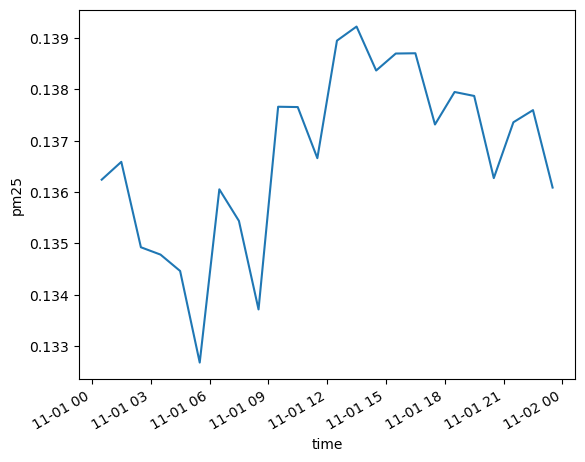

In [9]:
#time series plots

#dt -- min max avg max(diff in simultaneous readings) 
aq_data['pm25'].plot.line()

{'whiskers': [<matplotlib.lines.Line2D at 0x7facf566b520>,
 'caps': [<matplotlib.lines.Line2D at 0x7facf566ba60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7facf566b2b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7facf566bfa0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7facf567d280>],
 'means': []}

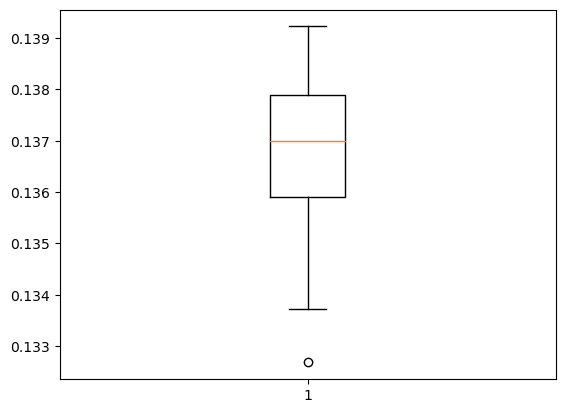

In [11]:
#region map
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.boxplot(aq_data['pm25'])

In [ ]:
#box plots

month_labels = ['Jan', 'Feb', 'March', 'April', 'May', 'June' 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
mean = [np.mean(d) for d in aq_data_by_monthy]
std_devs = [np.std(d) for d in aq_data_by_monthy]
plt.boxplot(aq_data_by_monthy, positions=[1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12], labels=month_labels)
for i in range(len(mean)):
   plt.plot(i + 1, mean[i], 'ro')
# Adds standard deviations as error bars
for i in range(len(std_devs)):
   plt.errorbar(i + 1, mean[i], yerr=std_devs[i], fmt='o', color='red')
plt.title('PM 2.5 Boxplot, 1 year; with Means and Standard Deviations') 
plt.xlabel('2023')
plt.ylabel('PM 2.5 Concentration')
plt.show()
